# Employee Turnover Analytics - Course-end Project 1
**Simplilearn AI & ML PGP | Portobello Tech HR Dataset**

This notebook covers:
1. Data quality checks (missing values)
2. EDA - factors contributing to employee turnover
3. Clustering of employees who left (satisfaction & evaluation)
4. Class imbalance handling with SMOTE
5. K-fold cross-validation model training and evaluation
6. Best model selection with justified metrics
7. Retention strategies for targeted employees

In [3]:
%pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn]
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix)
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Load Data & Data Quality Checks
Load HR dataset and check for missing values.

In [4]:
# Load dataset (use path relative to notebook location)
df = pd.read_csv('HR_comma_sep.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (14999, 10)

First 5 rows:


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# Data quality checks - Missing values
print("=== DATA QUALITY CHECKS ===\n")
print("Missing values per column:")
print(df.isnull().sum())
print("\nTotal missing values:", df.isnull().sum().sum())
print("\nData types:\n", df.dtypes)
print("\nBasic statistics:")
df.describe()

=== DATA QUALITY CHECKS ===

Missing values per column:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

Total missing values: 0

Data types:
 satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

Basic statistics:


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Target 'left' distribution:
left
0    11428
1     3571
Name: count, dtype: int64

Percentage:
left
0    76.2
1    23.8
Name: proportion, dtype: float64


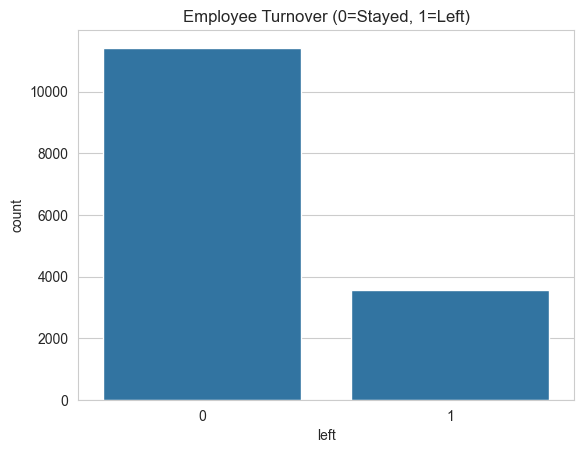

In [8]:
# Class distribution (target: left)
print("Target 'left' distribution:")
print(df['left'].value_counts())
print("\nPercentage:")
print(df['left'].value_counts(normalize=True).round(3) * 100)
sns.countplot(data=df, x='left')
plt.title('Employee Turnover (0=Stayed, 1=Left)')
plt.show()

## 2. Exploratory Data Analysis - Factors Contributing to Turnover
Understand which factors contribute most to employee turnover.

Correlation with 'left' (absolute):
 satisfaction_level      -0.388375
Work_accident           -0.154622
time_spend_company       0.144822
average_montly_hours     0.071287
promotion_last_5years   -0.061788
number_project           0.023787
last_evaluation          0.006567
Name: left, dtype: float64


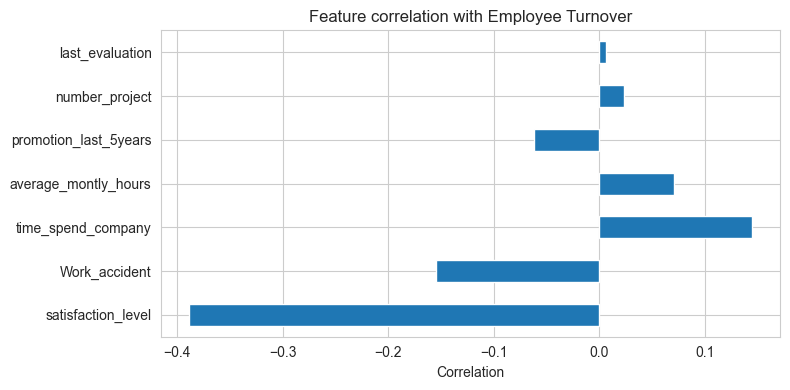

In [11]:
# Correlation with target
df_numeric = df.select_dtypes(include=[np.number])
corr_with_left = df_numeric.corr()['left'].drop('left').sort_values(key=abs, ascending=False)
print("Correlation with 'left' (absolute):\n", corr_with_left)
corr_with_left.plot(kind='barh', figsize=(8,4))
plt.title('Feature correlation with Employee Turnover')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

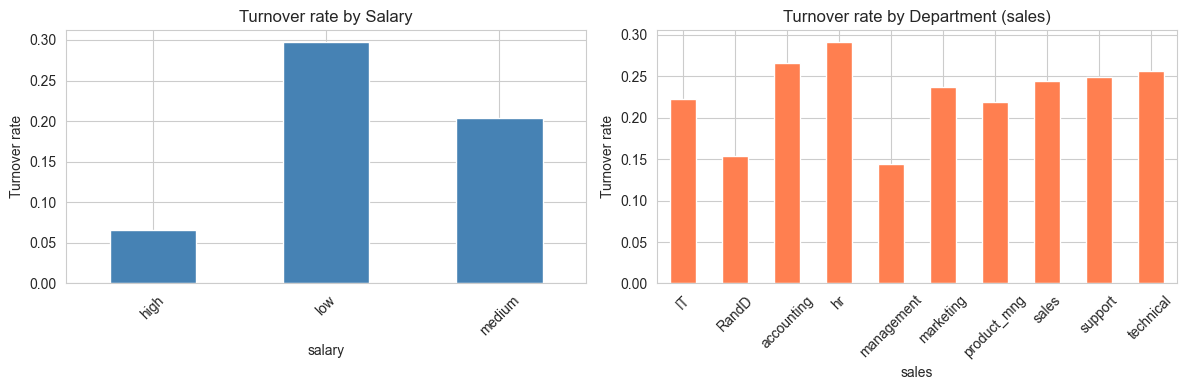

In [13]:
# Turnover rate by categorical features
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df.groupby('salary')['left'].mean().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Turnover rate by Salary')
axes[0].set_ylabel('Turnover rate')
axes[0].tick_params(axis='x', rotation=45)
df.groupby('sales')['left'].mean().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Turnover rate by Department (sales)')
axes[1].set_ylabel('Turnover rate')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

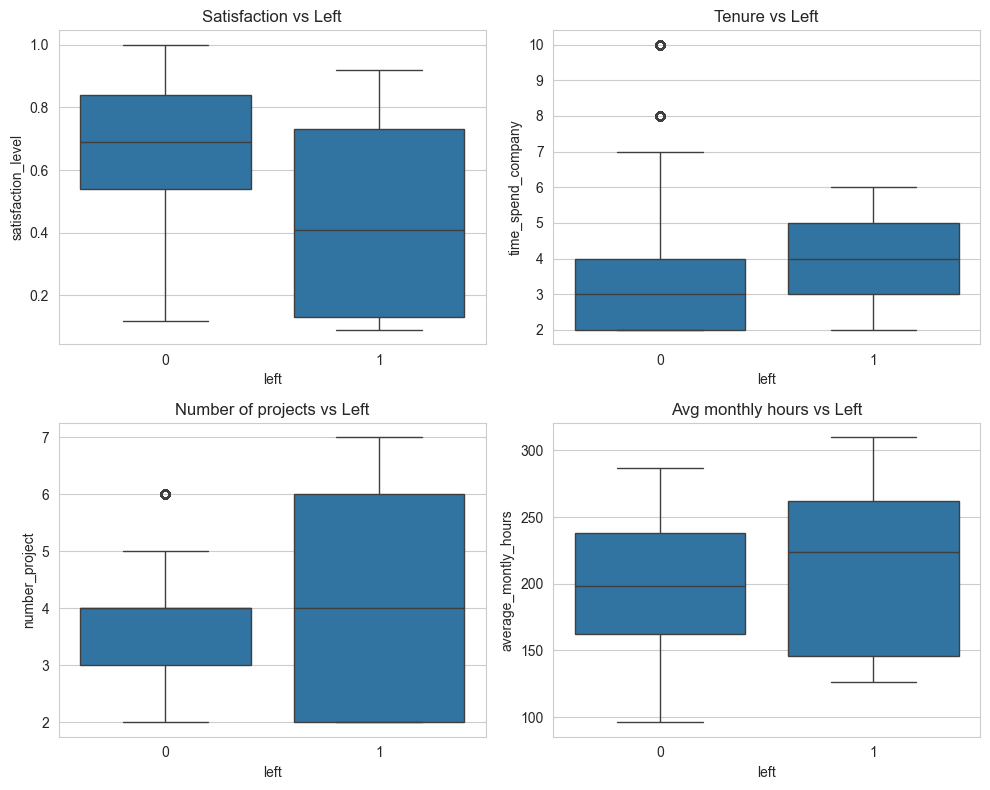


EDA Summary: Low satisfaction, longer tenure, high hours and project count associate with higher turnover.


In [15]:
# Key numeric factors: satisfaction_level, time_spend_company, number_project
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(data=df, x='left', y='satisfaction_level', ax=axes[0,0])
axes[0,0].set_title('Satisfaction vs Left')
sns.boxplot(data=df, x='left', y='time_spend_company', ax=axes[0,1])
axes[0,1].set_title('Tenure vs Left')
sns.boxplot(data=df, x='left', y='number_project', ax=axes[1,0])
axes[1,0].set_title('Number of projects vs Left')
sns.boxplot(data=df, x='left', y='average_montly_hours', ax=axes[1,1])
axes[1,1].set_title('Avg monthly hours vs Left')
plt.tight_layout()
plt.show()
print("\nEDA Summary: Low satisfaction, longer tenure, high hours and project count associate with higher turnover.")

## 3. Clustering of Employees Who Left (Satisfaction & Evaluation)
Cluster employees who left based on satisfaction_level and last_evaluation.

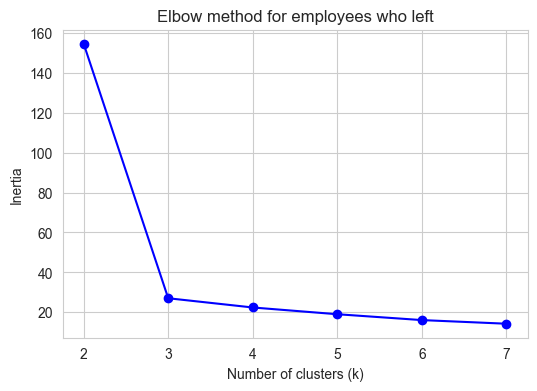

In [18]:
# Subset: employees who left
df_left = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']].copy()
# Elbow method for optimal k
inertias = []
K = range(2, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_left)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(6, 4))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method for employees who left')
plt.show()

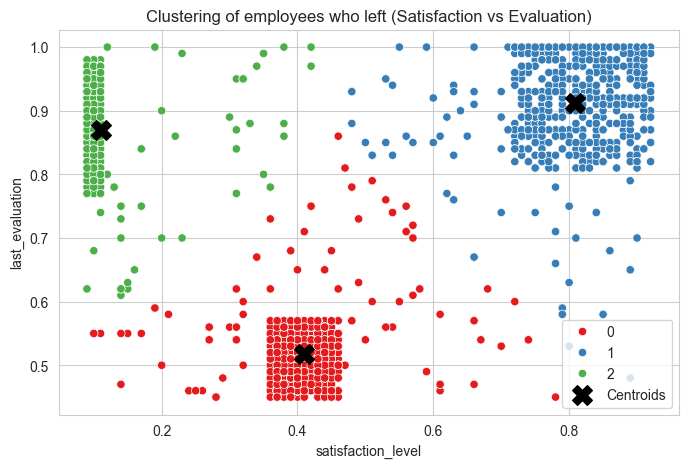

Cluster sizes: cluster
0    1650
1     977
2     944
Name: count, dtype: int64


In [20]:
# K-Means clustering with k=3 (typical elbow around 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_left['cluster'] = kmeans.fit_predict(df_left)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_left, x='satisfaction_level', y='last_evaluation', hue='cluster', palette='Set1')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroids')
plt.title('Clustering of employees who left (Satisfaction vs Evaluation)')
plt.legend()
plt.show()
print("Cluster sizes:", df_left['cluster'].value_counts().sort_index())

## 4. Data Preprocessing & SMOTE for Class Imbalance
Encode categoricals, scale features, and apply SMOTE to balance the 'left' class.

In [23]:
# Encode categorical columns
df_ml = df.copy()
le_sales = LabelEncoder()
le_salary = LabelEncoder()
df_ml['sales_enc'] = le_sales.fit_transform(df_ml['sales'])
df_ml['salary_enc'] = le_salary.fit_transform(df_ml['salary'])
# Features and target
feature_cols = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours',
               'time_spend_company', 'Work_accident', 'promotion_last_5years', 'sales_enc', 'salary_enc']
X = df_ml[feature_cols]
y = df_ml['left']
# Train-test split first (SMOTE only on training set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Before SMOTE - Train:", y_train.value_counts().to_dict())

Before SMOTE - Train: {0: 9142, 1: 2857}


In [25]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Apply SMOTE on training data only
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE - Train:", pd.Series(y_train_bal).value_counts().to_dict())

After SMOTE - Train: {0: 9142, 1: 9142}


## 5. K-Fold Cross-Validation & Model Training
Train multiple classifiers with stratified k-fold CV and evaluate performance.

In [28]:
# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}
cv_results = {}
for name, model in models.items():
    scores_acc = cross_val_score(model, X_train_bal, y_train_bal, cv=cv, scoring='accuracy')
    scores_f1 = cross_val_score(model, X_train_bal, y_train_bal, cv=cv, scoring='f1')
    scores_roc = cross_val_score(model, X_train_bal, y_train_bal, cv=cv, scoring='roc_auc')
    cv_results[name] = {'accuracy': scores_acc.mean(), 'f1': scores_f1.mean(), 'roc_auc': scores_roc.mean()}
    print(f"{name}: CV Accuracy={scores_acc.mean():.3f}, F1={scores_f1.mean():.3f}, ROC-AUC={scores_roc.mean():.3f}")
cv_df = pd.DataFrame(cv_results).T
cv_df

Logistic Regression: CV Accuracy=0.762, F1=0.768, ROC-AUC=0.817
Random Forest: CV Accuracy=0.990, F1=0.990, ROC-AUC=0.999
Gradient Boosting: CV Accuracy=0.966, F1=0.965, ROC-AUC=0.993


,accuracy,f1,roc_auc
Logistic Regression,0.761978,0.767872,0.816927
Random Forest,0.989827,0.989756,0.998775
Gradient Boosting,0.965653,0.965218,0.993267


In [35]:
# Train final models on full balanced train set and evaluate on test set (no SMOTE)
results = []
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_scaled)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    })
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.762000,0.500000,0.778711,0.608981,0.822411
1,Random Forest,0.990667,0.994236,0.966387,0.980114,0.992312
2,Gradient Boosting,0.965667,0.921379,0.935574,0.928423,0.989849


## 6. Best Model Selection & Evaluation Metrics Justification
We use **F1-Score** and **ROC-AUC** as primary metrics because turnover is a class-imbalanced problem: we care about correctly identifying employees who will leave (minority class) without excessive false positives. Accuracy alone can be misleading.

Best model (by F1-Score): Random Forest
Model        Random Forest
Accuracy          0.990667
Precision         0.994236
Recall            0.966387
F1-Score          0.980114
ROC-AUC           0.992312
Name: 1, dtype: object

Classification Report (Best Model):
              precision    recall  f1-score   support

      Stayed       0.99      1.00      0.99      2286
        Left       0.99      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2282    4]
 [  24  690]]


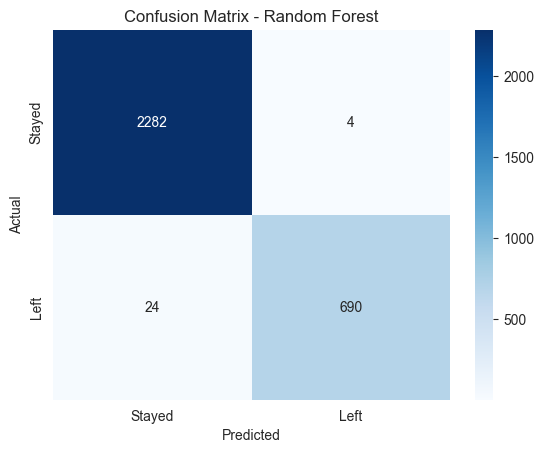

In [31]:
# Best model by F1 (and ROC-AUC for robustness)
best_by_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
print("Best model (by F1-Score):", best_by_f1['Model'])
print(best_by_f1)
best_model_name = best_by_f1['Model']
best_model = models[best_model_name]
best_model.fit(X_train_bal, y_train_bal)
y_pred_best = best_model.predict(X_test_scaled)
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best, target_names=['Stayed', 'Left']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 7. Retention Strategies for Targeted Employees
Based on EDA and clustering, we recommend the following retention strategies for employees at risk of leaving:

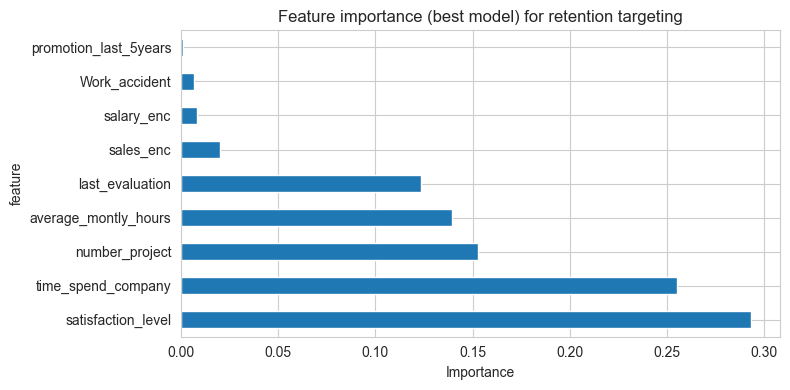

                 feature  importance
0     satisfaction_level    0.293491
4     time_spend_company    0.254973
2         number_project    0.153020
3   average_montly_hours    0.139348
1        last_evaluation    0.123520
7              sales_enc    0.020054
8             salary_enc    0.008201
5          Work_accident    0.006514
6  promotion_last_5years    0.000879


In [33]:
# Feature importance (for tree-based best model) to target interventions
if hasattr(best_model, 'feature_importances_'):
    imp = pd.DataFrame({'feature': feature_cols, 'importance': best_model.feature_importances_})
    imp = imp.sort_values('importance', ascending=False)
    imp.plot(x='feature', y='importance', kind='barh', legend=False, figsize=(8, 4))
    plt.title('Feature importance (best model) for retention targeting')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    print(imp)

In [34]:
print("""
RETENTION STRATEGIES (Targeted by risk factors):

1. LOW SATISFACTION: Conduct stay interviews and pulse surveys; address workload, recognition, and work-life balance.
2. HIGH TENURE + BURNOUT: Offer sabbaticals, role rotation, or project variety; review promotion and growth paths.
3. HIGH HOURS / OVERLOAD: Cap overtime, redistribute projects, and hire to reduce average_montly_hours.
4. LOW SALARY (vs market): Benchmark compensation; consider raises or bonuses for high performers.
5. NO PROMOTION (promotion_last_5years=0): Clear career ladder and internal mobility programs.
6. DEPARTMENT-SPECIFIC: Tailor interventions by sales/technical/support (e.g., sales: quotas and incentives; technical: learning budget).

Using the model: Score current employees; target retention efforts on those predicted as 'left' with highest probability.
""")


RETENTION STRATEGIES (Targeted by risk factors):

1. LOW SATISFACTION: Conduct stay interviews and pulse surveys; address workload, recognition, and work-life balance.
2. HIGH TENURE + BURNOUT: Offer sabbaticals, role rotation, or project variety; review promotion and growth paths.
3. HIGH HOURS / OVERLOAD: Cap overtime, redistribute projects, and hire to reduce average_montly_hours.
4. LOW SALARY (vs market): Benchmark compensation; consider raises or bonuses for high performers.
5. NO PROMOTION (promotion_last_5years=0): Clear career ladder and internal mobility programs.
6. DEPARTMENT-SPECIFIC: Tailor interventions by sales/technical/support (e.g., sales: quotas and incentives; technical: learning budget).

Using the model: Score current employees; target retention efforts on those predicted as 'left' with highest probability.

